In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as function
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import pandas as pd
if torch.cuda.is_available()==False:
    raise ImportError
from tookit import precision #this programe is used to strore commonly used functions

In [58]:
picture_width=500
picture_height=500 #the width and height of picture in cartoon
classesNum=5 #male or female
epochs=2 #how much epoch I need to run
batch_size0 =10 #I want to train it with minibatch.
#there are 5000 images in celeba dataset
img_path=os.getcwd()[:-2]+"Datasets\\cartoon_set" #[:-2]for deleting "B1"

feature_size=2
#I will double the feature_size after every pooling layer.so if you set feature_size to a very big number,
#It will become very slow

In [59]:
def label_loader(gloabel_path:str,label_index:int):
    """ this class is for loading the label of picture.The label of picture is not well formated  
    """
    new_label_path=gloabel_path+'\\labels.csv'
    labels_original=pd.read_csv(new_label_path)  
    labelsNew=[]
    for row in labels_original.iterrows():
    #self.labels is a Dataframe,we can only use .iterrows()method to iter a dataframe
        splitedLabel=str(row).split('\\t')
        #print(splitedLabel)
        #break    when you want to find the label_index,run theis part
        labelsNew.append(int(splitedLabel[label_index]))
    return labelsNew

In [60]:
#this class is for loading data.
class DatasetCreater(Dataset):
    def __init__(self,path:str,start_item:int,data_size:int,data_format:str,transformer:object,labels):
        #transformer is an object created by torchvision.transforms.Compose()to transform an picture from PIL object to tensor
        super().__init__()
        self.path=path
        self.start_item=start_item
        self.data_size=data_size
        self.transformer=transformer
        self.data_format=data_format
        
        #labels.Labels is small so I want to load every labes in the initial process
        #pictures are big so I want to load it when I need to use it
        self.labels=labels
        
    def __len__(self):
        return self.data_size
    #哈哈，枚举类型和for循环也不知道可迭代对象有几个元素。他们就是通过__len__()函数找要迭代多少次的。如果__len__函数大于
    #真实可迭代次数，就会报错
    
    def __getitem__(self, item):
        #the path of one data
        OneDataPath=self.path+"\\img\\"+str(item+self.start_item)+"."+self.data_format
        image=Image.open(OneDataPath).convert('RGB')
        imageTensor=self.transformer(image)

        label=self.labels[item+self.start_item]
        return imageTensor,label

transformer_train = transforms.Compose(
    [
    transforms.RandomHorizontalFlip(p=0.1),#随机水平翻转 选择一个概率概率 randon horizontal Flip
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])         
])

transformer_test = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])         
])


labels= label_loader(img_path,5)

train_data=DatasetCreater(img_path,0,8000,"png",transformer_train,labels)
train_loader =DataLoader(
	dataset=train_data,
    batch_size=batch_size0,
    shuffle=True
	)
test_data=DatasetCreater(img_path,8000,2000,"png",transformer_test,labels)

test_loader =DataLoader(
	dataset=test_data,
    batch_size=batch_size0,
    shuffle=True
	)

In [61]:
#now ,I want to creat a neural network
class ConvolutionalNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.convModule=nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=feature_size,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(),
             nn.Conv2d(
                in_channels=feature_size,
                out_channels=feature_size,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2=nn.Sequential(
            nn.Conv2d(
                in_channels=feature_size,
                out_channels=2*feature_size,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(2*feature_size),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=2*feature_size,
                out_channels=2*feature_size,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(2*feature_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.outLayer=nn.Sequential(
            nn.Linear(62500,1000),
            nn.ReLU(),
            nn.Linear(1000,classesNum)
            )
        #this number 28512 is not good,I don't know how the outLayer number should be set
        #So If you change the input size of the picture,this neural net work will raise a 
        #error which is "mat1 and mat2 shapes cannot be multiplied (10x aNnumber and 28512x2)""
        #then,you should change 28512 to "aNumber"in there
    
    def forward(self,input):
        input1=self.convModule(input)
        input2=self.conv2(input1)
        #input3=self.conv3(input2)
        
        input4=input2.view(input2.size(0),-1)
        output=self.outLayer(input4)
        return output
        #we want to reshape the fature map into a vector

In [62]:
def parameter_selection(Ir):
        neuroNet=ConvolutionalNN().cuda()
        #next,I  define a loss function and an optimizer
        lossFunction=nn.CrossEntropyLoss()
        #Cross Entropy loss is linked to mutiple classification problems，one-hot label
        optimizer = optim.Adam(neuroNet.parameters(), Ir)
        #Adam and Nadam are the best
        #later,I want to choose the best Ir by model selection
        flag=0#flag for training times
        test_rights=[]
        training_batch_times=[]
        for i in range(epochs):
                for bach,label in train_loader: 
                        neuroNet.train()#set the test_loader_iter neural network to training model                        
                        output = neuroNet(bach.cuda())
                        loss = lossFunction(output,torch.tensor(label).cuda())

                        flag+=1
                        if flag%50==0:
                                # neuroNet.eval()
                                # print("training times=",flag)dd
                                torch.cuda.empty_cache()
                                test_batchs_number=0
                                sum_of_precision=0
                                for i,j in test_loader:
                                        sum_of_precision+=precision(neuroNet(i.cuda()).cpu(),j)
                                        #sum_of_precision+=precision(neuroNet(i),j)
                                        test_batchs_number+=1
                                test_right=sum_of_precision/test_batchs_number
                                print(test_right)
                                test_rights.append(test_right)
                                training_batch_times.append(flag)
                                if flag>=300:
                                        if test_right==max(test_rights) and test_right>0.92:
                                                return neuroNet,test_rights,training_batch_times
                        optimizer.zero_grad()#clean the grade 
                        loss.backward()
                        
                        optimizer.step()
        return neuroNet,test_rights,training_batch_times

In [63]:
#now,we want to select the best Ir and other parameters for our module
# for Ir in [0.001,0.0012,0.0014,0.0016]:
neuroNet,test_rights,training_batch_times=parameter_selection(0.001)
#torch.save(neuroNet.state_dict(), "./model_parameter.pkl")

# trained_model=ConvolutionalNN()
# trained_model.load_state_dict(torch.load("./model_parameter.pkl"))
# test_batchs_number=0
# sum_of_precision=0
# for i,j in test_loader:
#         sum_of_precision+=precision(trained_model(i),j)
#         test_batchs_number+=1
#         test_right=sum_of_precision/test_batchs_number
# print(test_right)


C:\Users\36161\AppData\Local\Temp\ipykernel_25472\1283774448.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = lossFunction(output,torch.tensor(label).cuda())


0.8350000000000005
0.9690000000000009
0.9700000000000009
0.9775000000000007
0.9870000000000003
0.9870000000000004


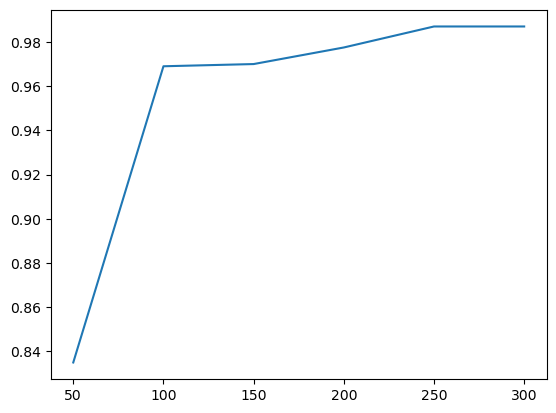

In [65]:
plt.plot(training_batch_times,test_rights)
plt.show()

In [66]:
torch.save(neuroNet.state_dict(), "./model_parameter.pkl")